In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [2]:
!pip install tensorflow tensorflow-federated tensorflow-privacy

In [5]:
!pip install tensorflow_addons
import os
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa  # For GroupNormalization

# Constants
IMG_SIZE = 48
BATCH_SIZE = 32
NUM_CLASSES = 7
DATA_DIR = "/kaggle/input/fer2013/train"
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_ROUNDS = 20

# Load grayscale images from a given emotion folder
def load_images_from_folder(folder, label):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images = []
    labels = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((IMG_SIZE, IMG_SIZE))
        images.append(np.array(img))
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess the entire dataset
def preprocess_dataset():
    all_images = []
    all_labels = []
    for idx, emotion in enumerate(EMOTIONS):
        images, labels = load_images_from_folder(os.path.join(DATA_DIR, emotion), idx)
        all_images.append(images)
        all_labels.append(labels)
    X = np.concatenate(all_images)
    y = np.concatenate(all_labels)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
    y = tf.keras.utils.to_categorical(y, NUM_CLASSES)
    return X, y

# Create data augmentation pipeline with minimal intensity
def augment_data():
    return tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.03),  # Further reduced rotation
        tf.keras.layers.RandomZoom(0.03),     # Further reduced zoom
        tf.keras.layers.RandomTranslation(0.03, 0.03),  # Further reduced translation
        tf.keras.layers.RandomFlip("horizontal")
    ])

# Split data among federated clients with augmentation
def create_federated_data(X, y, num_clients=5):
    client_data = []
    size_per_client = len(X) // num_clients
    augmenter = augment_data()
    
    for i in range(num_clients):
        start = i * size_per_client
        end = (i + 1) * size_per_client if i < num_clients - 1 else len(X)
        client_dataset = tf.data.Dataset.from_tensor_slices((X[start:end], y[start:end]))
        client_dataset = client_dataset.map(
            lambda x, y: (augmenter(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        client_dataset = client_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        client_data.append(client_dataset)
    return client_data

# Build an improved CNN model with GroupNormalization
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1), padding='same'),
        tfa.layers.GroupNormalization(groups=8),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tfa.layers.GroupNormalization(groups=8),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tfa.layers.GroupNormalization(groups=8),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Load and preprocess dataset
X, y = preprocess_dataset()

# Split dataset for centralized evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare federated datasets
train_data = create_federated_data(X_train, y_train, num_clients=5)

# Create TFF model function
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

# Build federated training process using FedAvg
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.01),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.5)
)

# Initialize training state
state = iterative_process.initialize()

# Train model for defined number of federated rounds
for round_num in range(1, NUM_ROUNDS + 1):
    result = iterative_process.next(state, train_data)
    state = result.state
    train_metrics = result.metrics
    print(f'Round {round_num}, Metrics: {train_metrics}')

# Create new Keras model for centralized evaluation
final_model = create_keras_model()

# Debug: Print Keras model weight shapes
print("Keras model weight shapes:")
for w in final_model.get_weights():
    print(w.shape)

# Extract trained weights from the final TFF state
final_weights = state.global_model_weights
all_weights = final_weights.trainable + final_weights.non_trainable

# Debug: Print TFF model weight shapes
print("TFF model weight shapes:")
for w in all_weights:
    print(w.shape)

# Set weights to the Keras model
final_model.set_weights(all_weights)

# Compile and evaluate the model on the centralized test set
final_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

test_results = final_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)
print("\nCentralized Evaluation Results on Test Set:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Save the trained model
final_model.save('emotion_model_improved.h5')
print("Model saved to emotion_model_improved.h5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.2 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.19101319), ('loss', 2.1718256), ('num_examples', 22967), ('num_batches', 720)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.1951931), ('loss', 1.9773201), ('num_examples', 22967), ('num_batches', 720)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.20581704), ('loss', 1.8949206), ('num_examples', 22967), ('num_batches', 720)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDi

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Loaded saved model from emotion_model.h5
5742/5742 - 39s - loss: 1.5721 - categorical_accuracy: 0.3844 - 39s/epoch - 7ms/step

Centralized Evaluation Results on Test Set:
Test Loss: 1.5721
Test Accuracy: 0.3844
Iteration 0, Gradient Loss: 0.4212
Iteration 200, Gradient Loss: 0.2808
Iteration 400, Gradient Loss: 0.2787
Iteration 600, Gradient Loss: 0.2338
Iteration 800, Gradient Loss: 0.2375
Iteration 1000, Gradient Loss: 0.2420
Iteration 1200, Gradient Loss: 0.2203
Iteration 1400, Gradient Loss: 0.2110
Iteration 1600, Gradient Loss: 0.2238
Iteration 1800, Gradient Loss: 0.2176
SSIM between original and reconstructed images: 0.0075
iDLG attack results saved to idlg_attack_results_single_image.png


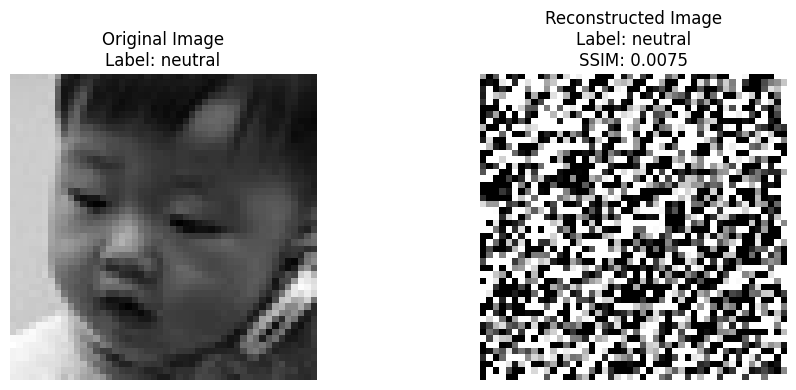

In [7]:
#step2
import os
import tensorflow as tf
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Constants
IMG_SIZE = 48
BATCH_SIZE = 1  # Single image for better reconstruction
NUM_CLASSES = 7
DATA_DIR = "/kaggle/input/fer2013/train"
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load grayscale images from a given emotion folder
def load_images_from_folder(folder, label):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images = []
    labels = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((IMG_SIZE, IMG_SIZE))
        images.append(np.array(img))
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess the entire dataset
def preprocess_dataset():
    all_images = []
    all_labels = []
    for idx, emotion in enumerate(EMOTIONS):
        images, labels = load_images_from_folder(os.path.join(DATA_DIR, emotion), idx)
        all_images.append(images)
        all_labels.append(labels)
    X = np.concatenate(all_images)
    y = np.concatenate(all_labels)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
    y = tf.keras.utils.to_categorical(y, NUM_CLASSES)
    return X, y

# Split data among federated clients
def create_federated_data(X, y, num_clients=5):
    client_data = []
    size_per_client = len(X) // num_clients
    for i in range(num_clients):
        start = i * size_per_client
        end = (i + 1) * size_per_client if i < num_clients - 1 else len(X)
        client_dataset = tf.data.Dataset.from_tensor_slices((X[start:end], y[start:end]))
        client_dataset = client_dataset.shuffle(100).batch(BATCH_SIZE)
        client_data.append(client_dataset)
    return client_data

# iDLG Attack Implementation with Label Recovery
def idlg_attack(model, original_gradients, original_images, num_iterations=2000):
    # Step 1: Recover labels using gradient information (iDLG approach)
    final_layer_grad = original_gradients[-2]  # Gradient of the last dense layer weights
    label_probs = tf.reduce_mean(tf.abs(final_layer_grad), axis=0)
    recovered_label = tf.one_hot(tf.argmax(label_probs), depth=NUM_CLASSES)
    recovered_labels = tf.tile(recovered_label[tf.newaxis, :], [BATCH_SIZE, 1])
    
    # Step 2: Initialize dummy images
    dummy_images = tf.Variable(tf.random.normal(original_images.shape), trainable=True)
    
    # Optimizer with learning rate scheduling
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=500, decay_rate=0.9
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Loss function for gradient matching
    def compute_gradient_loss():
        with tf.GradientTape() as tape:
            predictions = model(dummy_images)
            loss = tf.keras.losses.CategoricalCrossentropy()(recovered_labels, predictions)
        dummy_gradients = tape.gradient(loss, model.trainable_variables)
        # Compute mean squared error between dummy and original gradients
        grad_loss = 0
        for dg, og in zip(dummy_gradients, original_gradients):
            grad_loss += tf.reduce_mean(tf.square(dg - og))
        return grad_loss
    
    # Optimize dummy images
    for i in range(num_iterations):
        loss = compute_gradient_loss()
        optimizer.minimize(compute_gradient_loss, [dummy_images])
        if i % 200 == 0:
            print(f"Iteration {i}, Gradient Loss: {loss.numpy():.4f}")
    
    # Clip dummy images to valid range [0, 1]
    dummy_images_clipped = tf.clip_by_value(dummy_images, 0.0, 1.0)
    return dummy_images_clipped, recovered_labels

# Compute SSIM between original and reconstructed images
def compute_ssim(original, reconstructed):
    ssim_values = []
    for i in range(original.shape[0]):
        ssim_val = ssim(original[i, :, :, 0], reconstructed[i, :, :, 0], data_range=1.0)
        ssim_values.append(ssim_val)
    return np.mean(ssim_values)

# Load and preprocess dataset
X, y = preprocess_dataset()

# Split dataset for centralized evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare federated datasets with single-image batch
train_data = create_federated_data(X_train, y_train, num_clients=5)

# Load the saved model
final_model = tf.keras.models.load_model('emotion_model_improved.h5')
print("Loaded saved model from emotion_model.h5")

# Evaluate the loaded model to confirm it works
final_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
test_results = final_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)
print("\nCentralized Evaluation Results on Test Set:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Simulate Gradient Leakage Attack (iDLG) on a single client's batch
client_dataset = train_data[0]  # Take the first client's dataset
batch_images, batch_labels = next(iter(client_dataset))  # Get one batch (size=1)

# Compute original gradients for the batch
with tf.GradientTape() as tape:
    predictions = final_model(batch_images)
    loss = tf.keras.losses.CategoricalCrossentropy()(batch_labels, predictions)
original_gradients = tape.gradient(loss, final_model.trainable_variables)

# Run iDLG attack
reconstructed_images, reconstructed_labels = idlg_attack(final_model, original_gradients, batch_images)

# Compute SSIM
ssim_value = compute_ssim(batch_images.numpy(), reconstructed_images.numpy())
print(f"SSIM between original and reconstructed images: {ssim_value:.4f}")

# Visualize original vs. reconstructed images
num_images_to_show = min(1, batch_images.shape[0])  # Show 1 image
plt.figure(figsize=(10, 4))
for i in range(num_images_to_show):
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(batch_images[i, :, :, 0], cmap='gray')
    plt.title(f"Original Image\nLabel: {EMOTIONS[np.argmax(batch_labels[i])]}")
    plt.axis('off')
    
    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images[i, :, :, 0], cmap='gray')
    plt.title(f"Reconstructed Image\nLabel: {EMOTIONS[np.argmax(reconstructed_labels[i])]}\nSSIM: {ssim_value:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('idlg_attack_results_single_image.png')
print("iDLG attack results saved to idlg_attack_results_single_image.png")